## Imports and Data Wrangling

In [80]:
import sys
import math
import warnings

import psycopg2
import wrds
import gzip

import seaborn as sns
import os
import quandl
import json
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import functools
import requests
import io

import urllib.request
from urllib.error import HTTPError
# from html_table_parser.parser import HTMLTableParser
from bs4 import BeautifulSoup
import re

import plotnine as p9
from plotnine import ggplot, scale_x_date, guides, guide_legend, geom_bar, scale_y_continuous, \
    scale_color_identity, geom_line, geom_point, labs, theme_minimal, theme, element_blank, element_text, \
        geom_ribbon, geom_hline, aes, scale_size_manual, scale_color_manual, ggtitle

from datetime import datetime
import datetime

import pandas as pd
# import pandas_market_calendars as mcal
from pandas.plotting import autocorrelation_plot
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import scipy as sp
from scipy.stats import norm
import scipy.stats as stats

from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from collections import deque
from bisect import insort, bisect_left
from itertools import islice


In [81]:
calls = pd.read_csv('calls.csv')
puts = pd.read_csv('puts.csv')

In [82]:
datapull = pd.read_csv('spy_tickerdata.csv')

In [83]:
csv_file_path = 'C:/Users/jrecc/Grad_School_Winter_2024/FINM_33150/Project/option_data.csv'
spydata = pd.read_csv(csv_file_path)

In [84]:
spydata['date']=pd.to_datetime(spydata['date'], format = '%Y-%m-%d')
spydata['exdate']=pd.to_datetime(spydata['exdate'], format = '%Y-%m-%d')
spydata['dte'] = (spydata['exdate'] - spydata['date']).dt.days
mapping = {'C': 'Call', 'P': 'Put'}
spydata['Type'] = spydata['cp_flag'].map(mapping)

In [85]:
datapull[datapull['date'] == '2018-03-06']

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
6092,SPY,2018-03-06,273.3,273.39,271.18,272.88,78407902.0,0.0,1.0,246.987725,247.06906,245.071831,246.608161,78407902.0


In [86]:
calls[calls['date_x'] == '2021-02-08']

,date_x,exdate,last_date_x,cp_flag,strike_price,best_bid_x,best_offer_x,volume_x,open_interest_x,impl_volatility_x,...,vega_x,theta_x,expiry_indicator_x,close_x,adj_open_x,adj_close_x,adj_volume_x,TTE_x,close_date,is_present
780,2021-02-08,2021-03-10,2021-02-08,C,391.0,6.8,6.88,19.0,3.0,0.157962,...,44.66742,-43.18171,w,390.51,372.256242,373.442045,37887680.0,30,2021-03-01,True


In [87]:
first_options = spydata[(spydata['exdate'] == '2018-04-04') & (spydata['dte'] < 30) & (spydata['dte'] >=7) & (spydata['strike_price'] == 275000)]

In [88]:
middle_options = spydata[(spydata['exdate'] == '2021-03-10') & (spydata['dte'] < 30) & (spydata['dte'] >=7) & (spydata['strike_price'] == 391000)]

In [89]:
last_options = spydata[(spydata['exdate'] == '2022-07-06') & (spydata['dte'] < 30) & (spydata['dte'] >=7) & (spydata['strike_price'] == 412000)]

In [90]:
first_options = first_options.dropna()
middle_options = middle_options.dropna()
last_options = last_options.dropna()


## Graphs and Analysis

From the Delta Graphs below we can see that our positions open with call and put deltas each close to one half. As we hold the positions, the underlying moves up or down, and we can see the delta values diverge from one half and go either up or down. Our trading strategy will rebalance by buying and selling the underlying as the delta values change to keep a consistent portfolio Gamma. 

Note that under put-call parity, the Delta of a call option is always exactly 1 greater than the delta of a put option. In practice, this is almost always true, but with slight delays or lags/exceptions between time points.

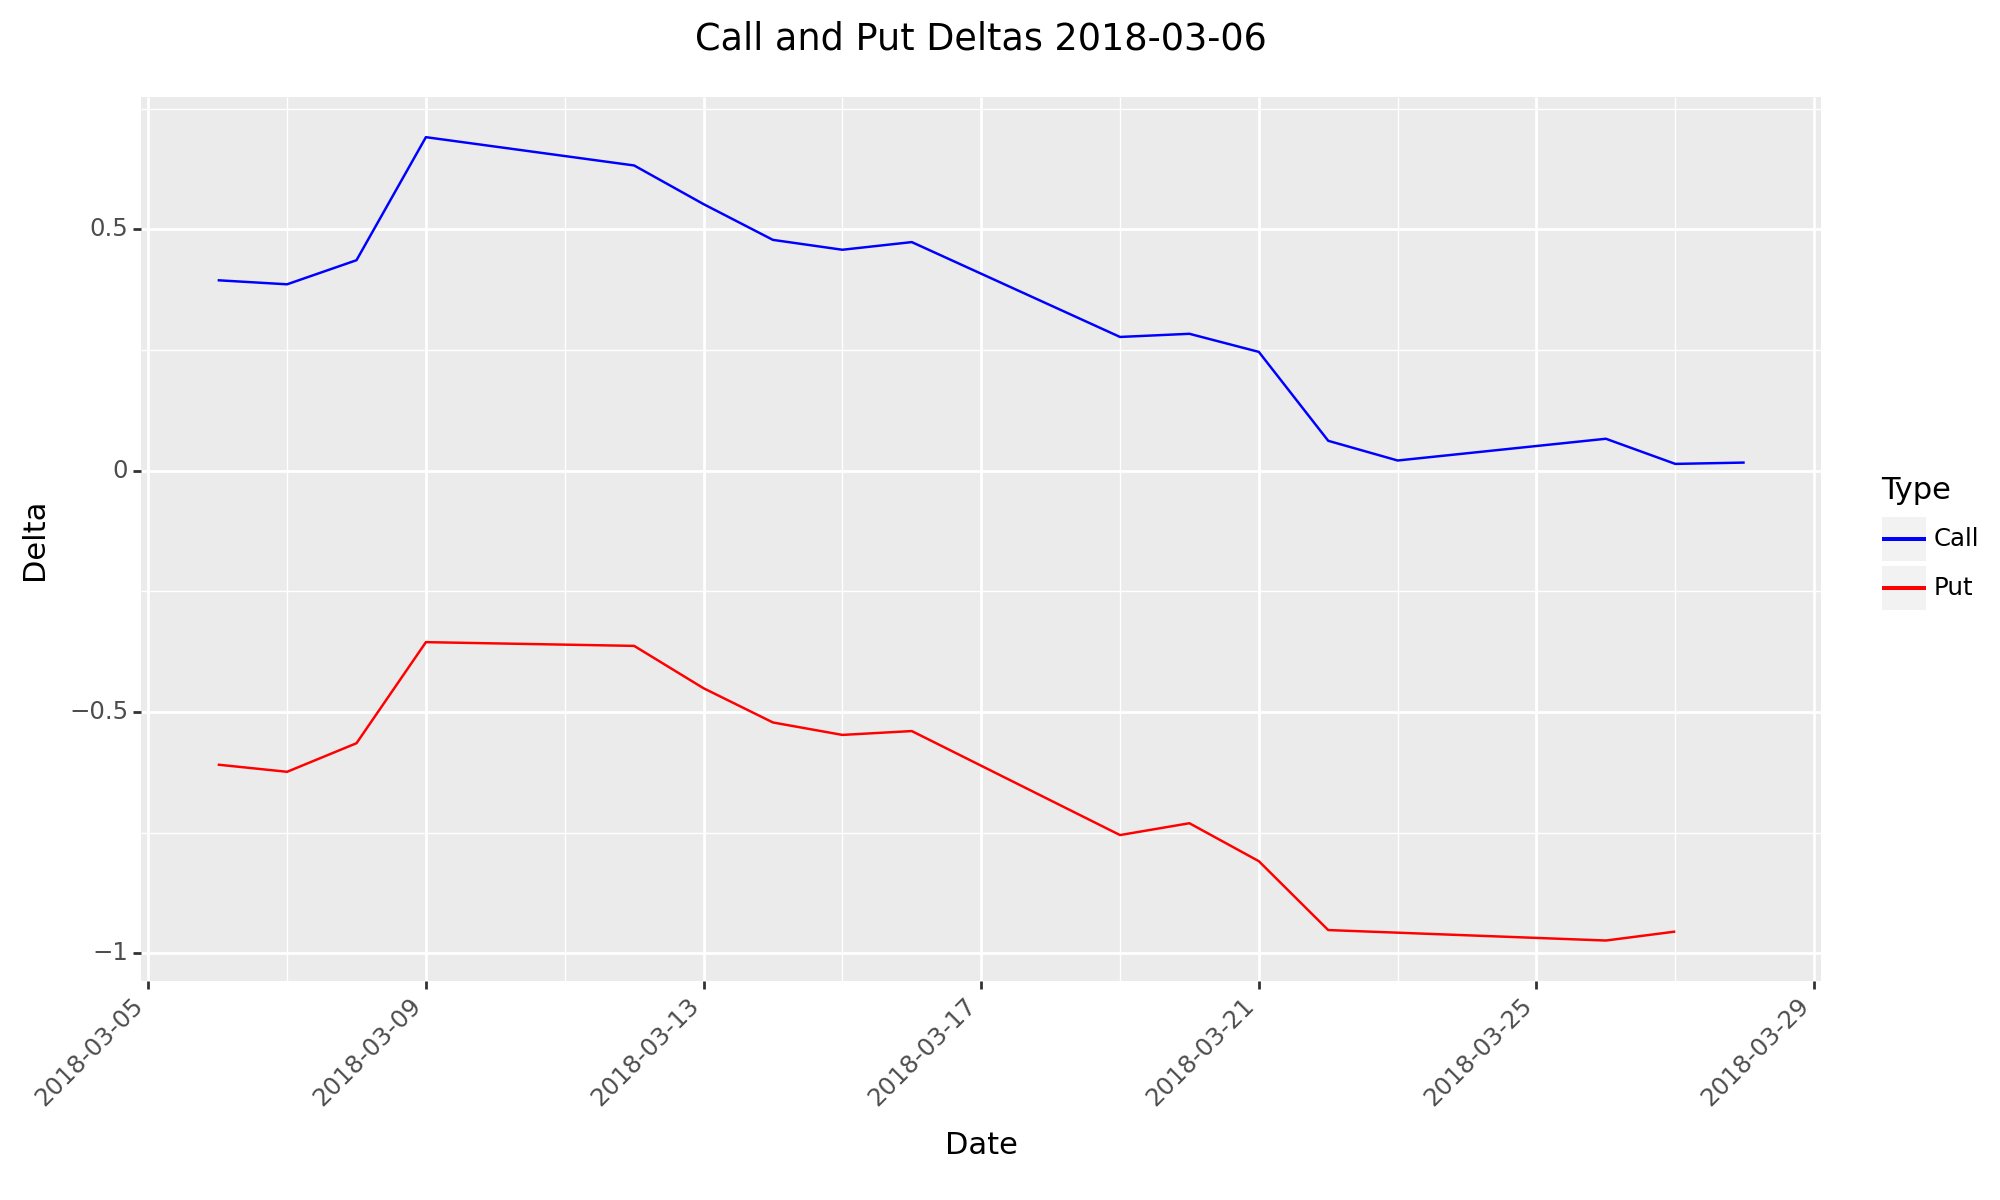

<Figure Size: (1000 x 600)>

In [91]:
p_d_1 = (ggplot(first_options, aes(x='date', y='delta', color='Type')) +
           geom_line() +
           labs(title='Call and Put Deltas 2018-03-06', x='Date', y='Delta', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Call": "blue", "Put": "red"}))
p_d_1

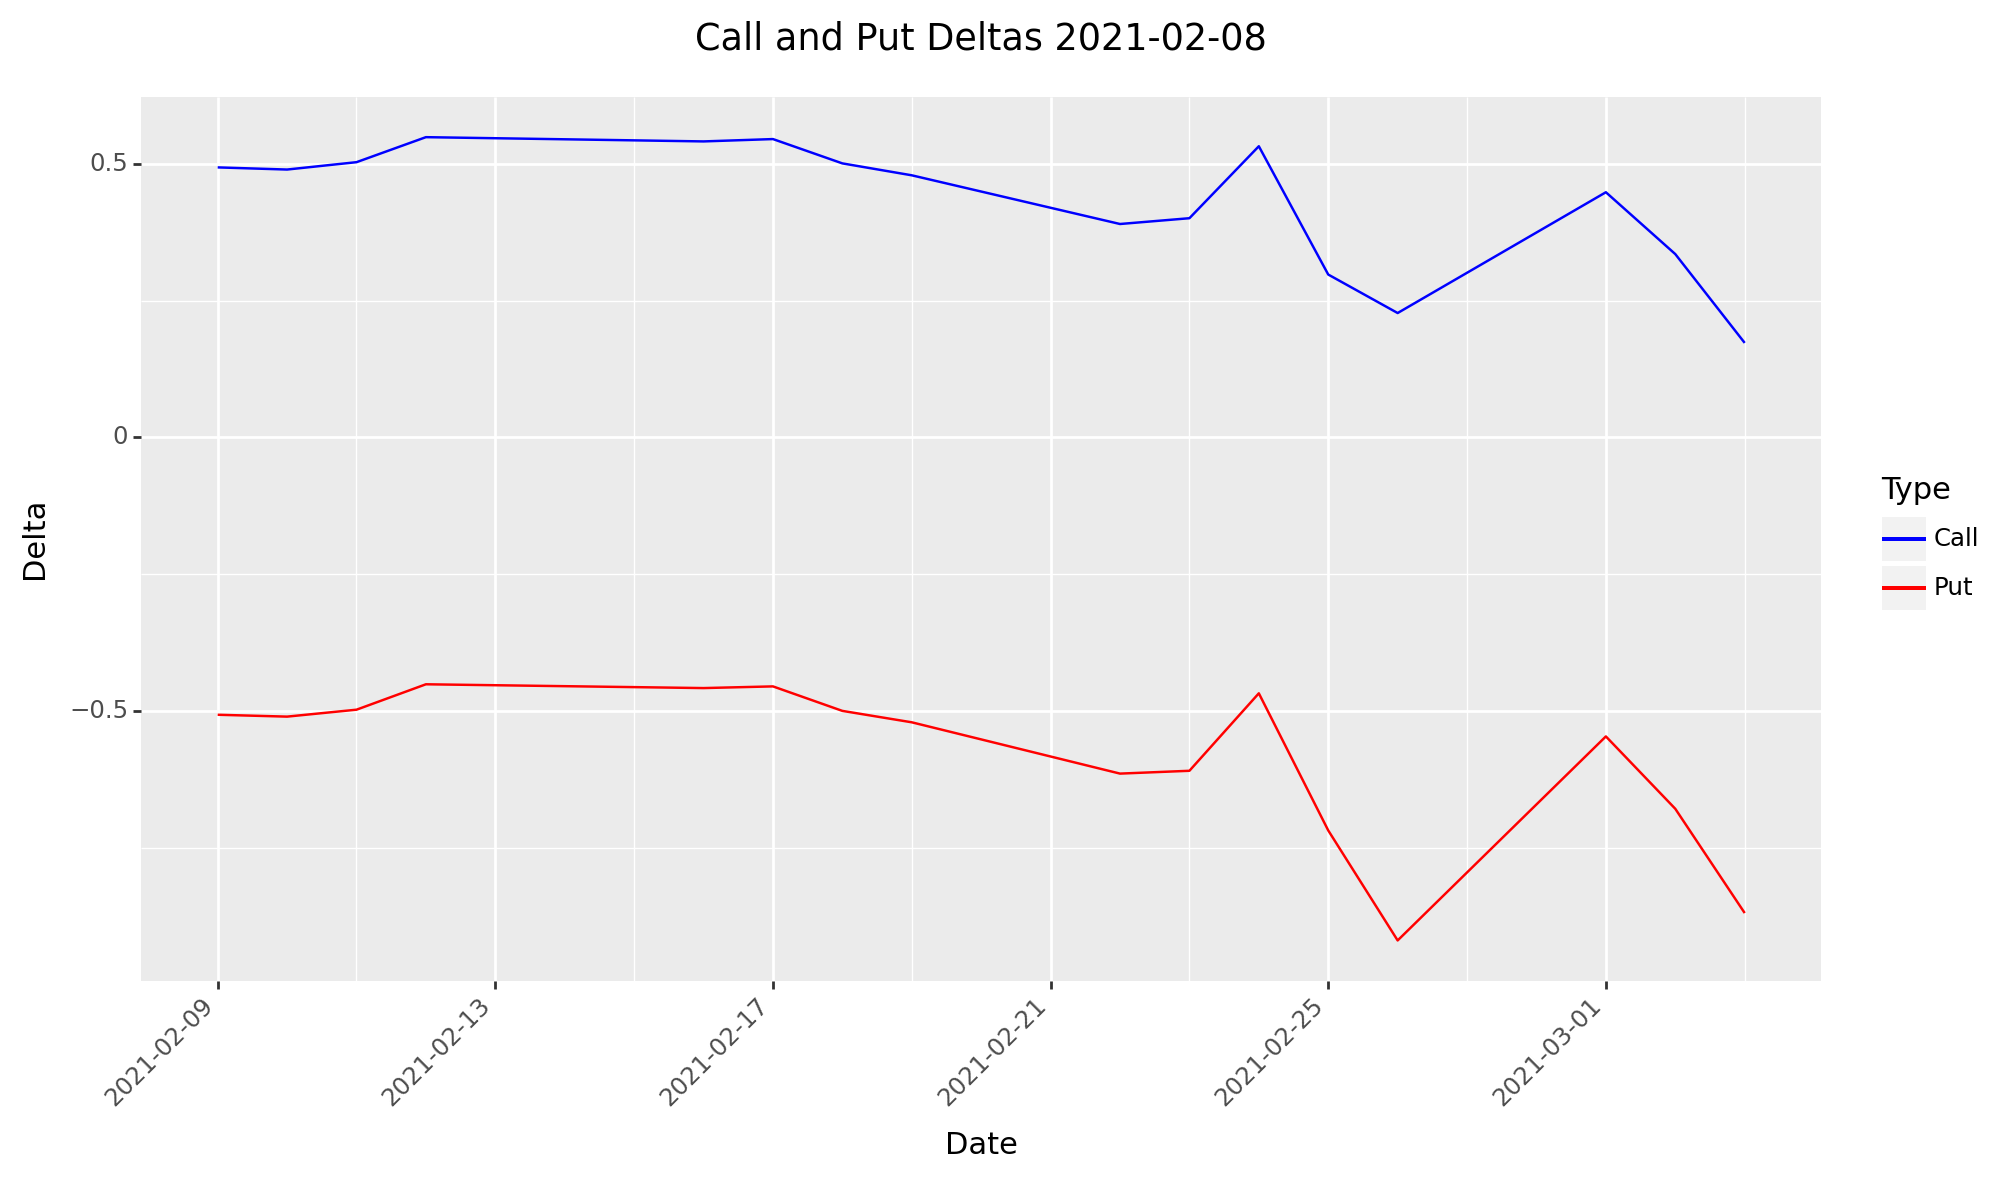

<Figure Size: (1000 x 600)>

In [92]:
p_d_2 = (ggplot(middle_options, aes(x='date', y='delta', color='Type')) +
           geom_line() +
           labs(title='Call and Put Deltas 2021-02-08', x='Date', y='Delta', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Call": "blue", "Put": "red"}))
p_d_2

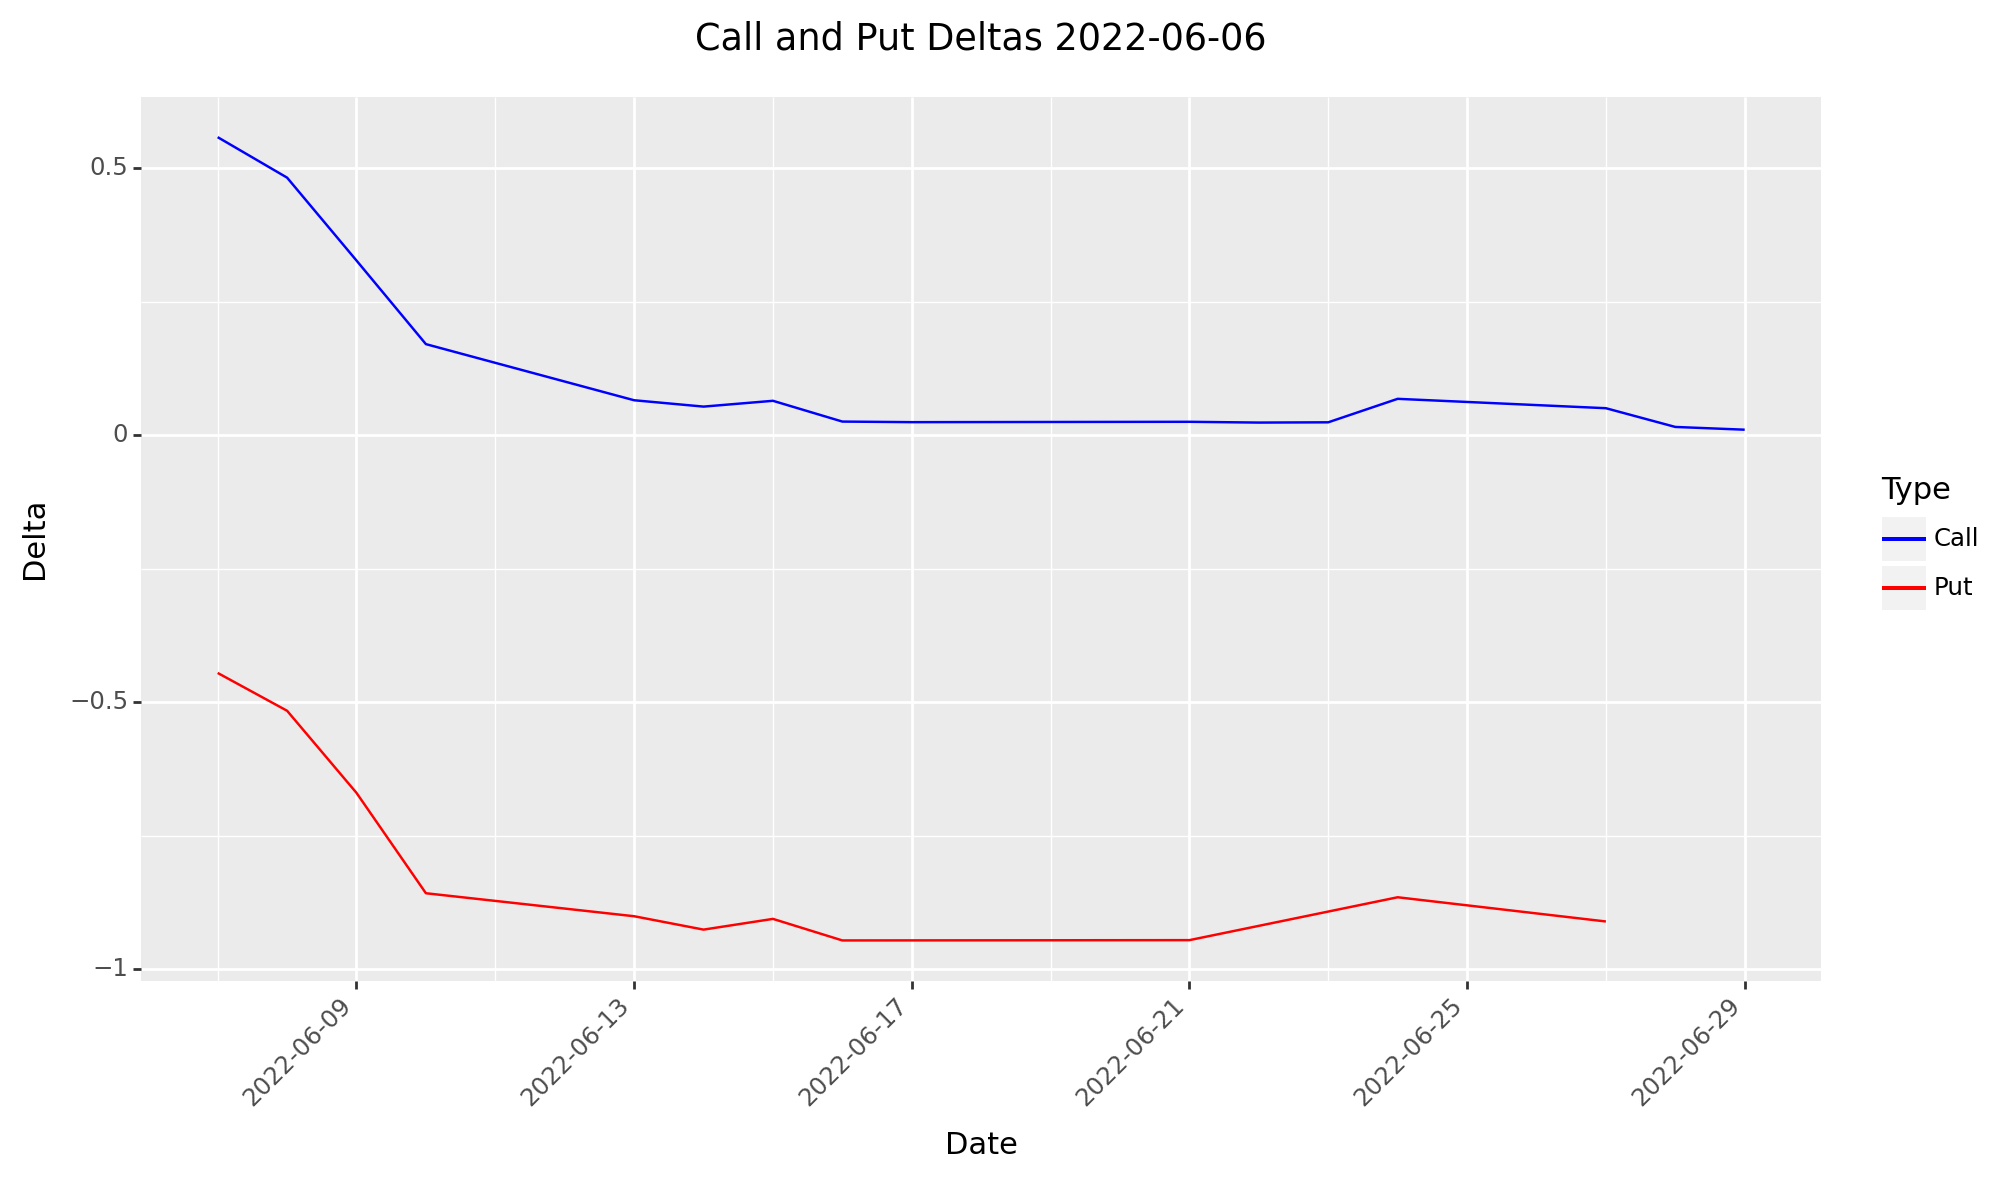

<Figure Size: (1000 x 600)>

In [93]:
p_d_3 = (ggplot(last_options, aes(x='date', y='delta', color='Type')) +
           geom_line() +
           labs(title='Call and Put Deltas 2022-06-06', x='Date', y='Delta', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Call": "blue", "Put": "red"}))
p_d_3

The graphs below show how Call and Put Gammas may change while we hold them. If the price of the underlying remains constant, the Gamma value will increase; if the price of the underlying decreases, the Gamma value will decrease. Our strategy hopes to identify times when Gamma will increase or decrease with a greater magnitude than the rest of the market assumes. If we anticipate more volatility in the underlying than the market does, we will go long Gamma. Conversely, if we anticipate less volatility than the market does, we will go short Gamma.

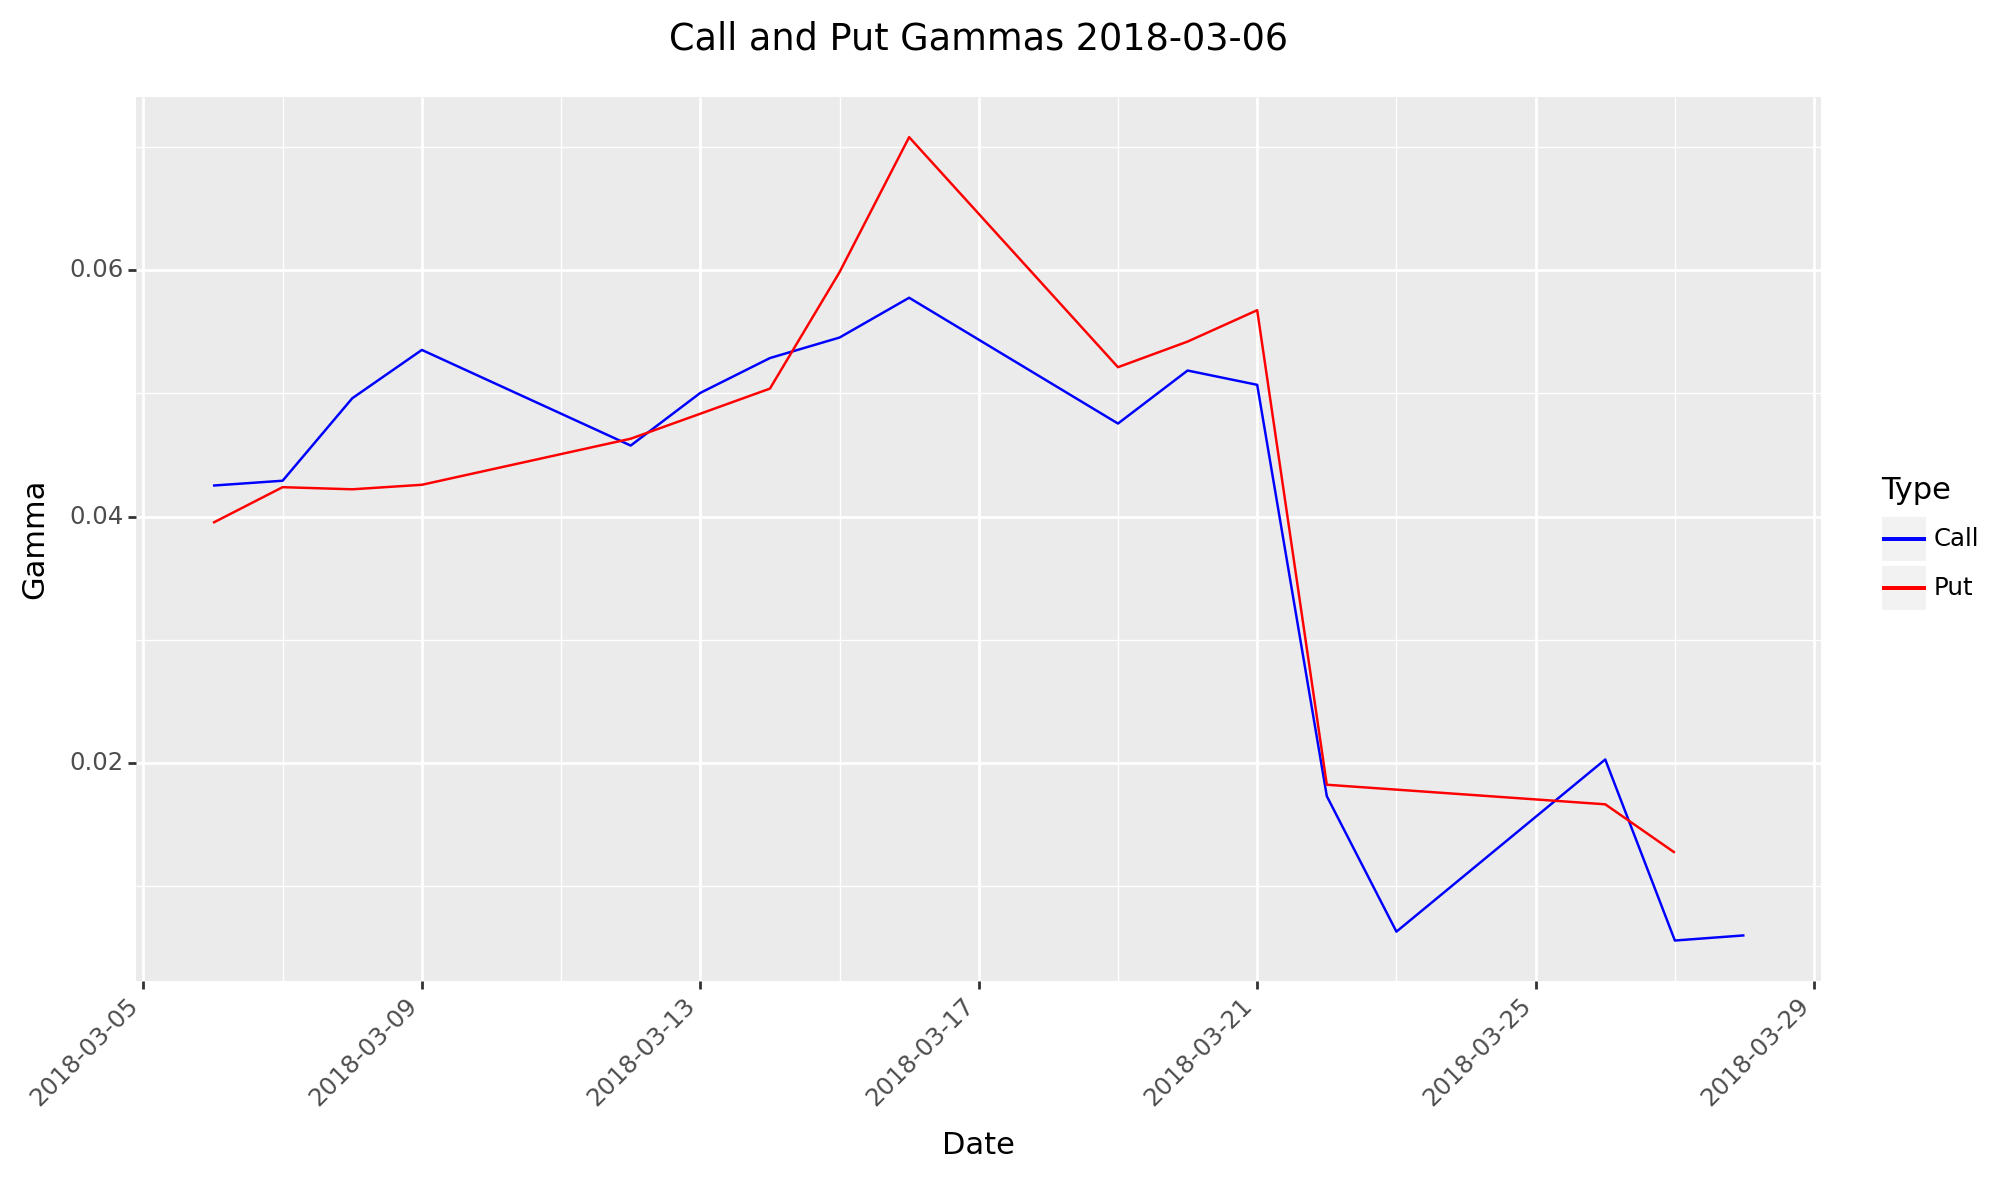

<Figure Size: (1000 x 600)>

In [94]:
p_g_1 = (ggplot(first_options, aes(x='date', y='gamma', color='Type')) +
           geom_line() +
           labs(title='Call and Put Gammas 2018-03-06', x='Date', y='Gamma', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Call": "blue", "Put": "red"}))
p_g_1

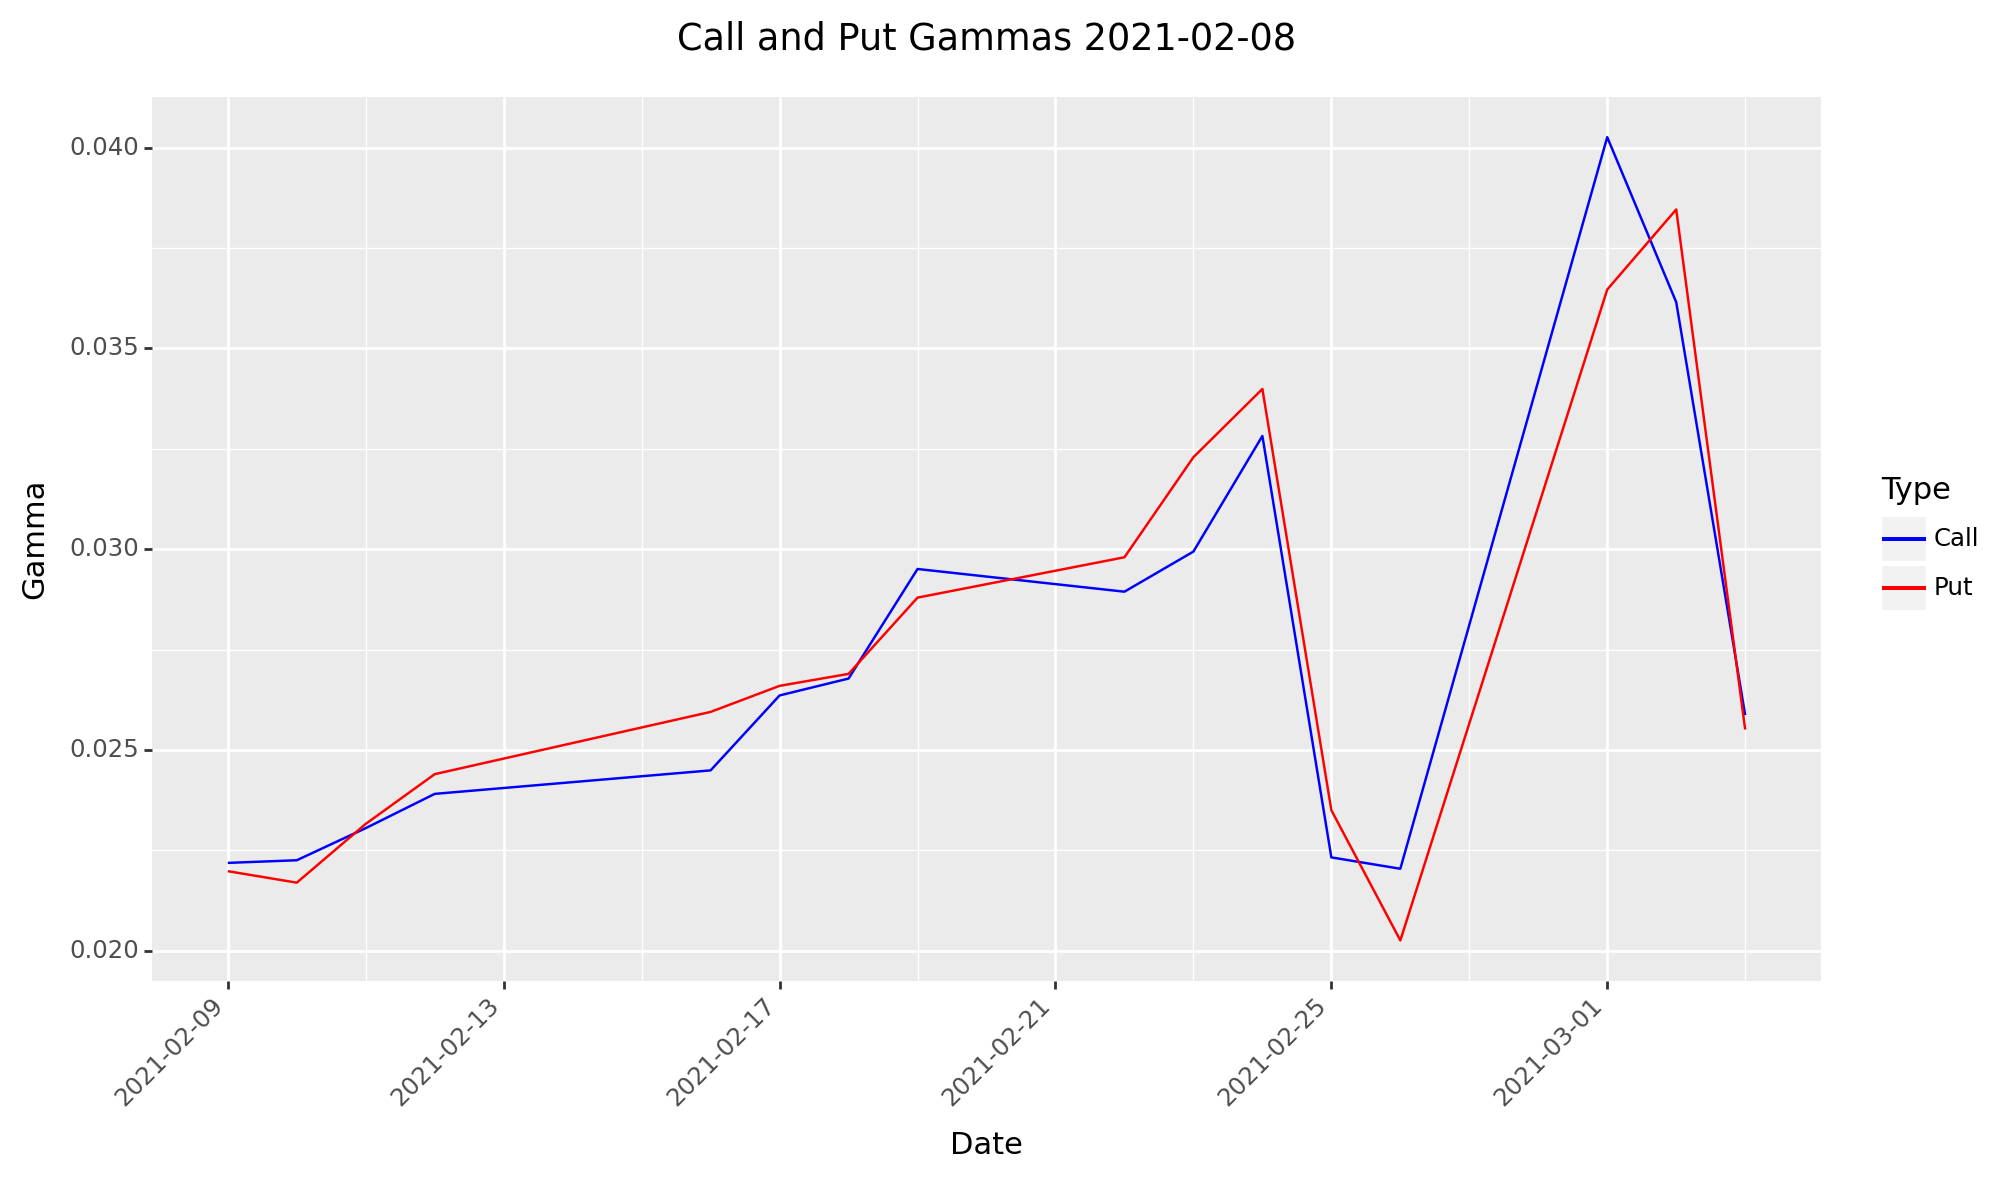

<Figure Size: (1000 x 600)>

In [97]:
p_g_2 = (ggplot(middle_options, aes(x='date', y='gamma', color='Type')) +
           geom_line() +
           labs(title='Call and Put Gammas 2021-02-08', x='Date', y='Gamma', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Call": "blue", "Put": "red"}))
p_g_2

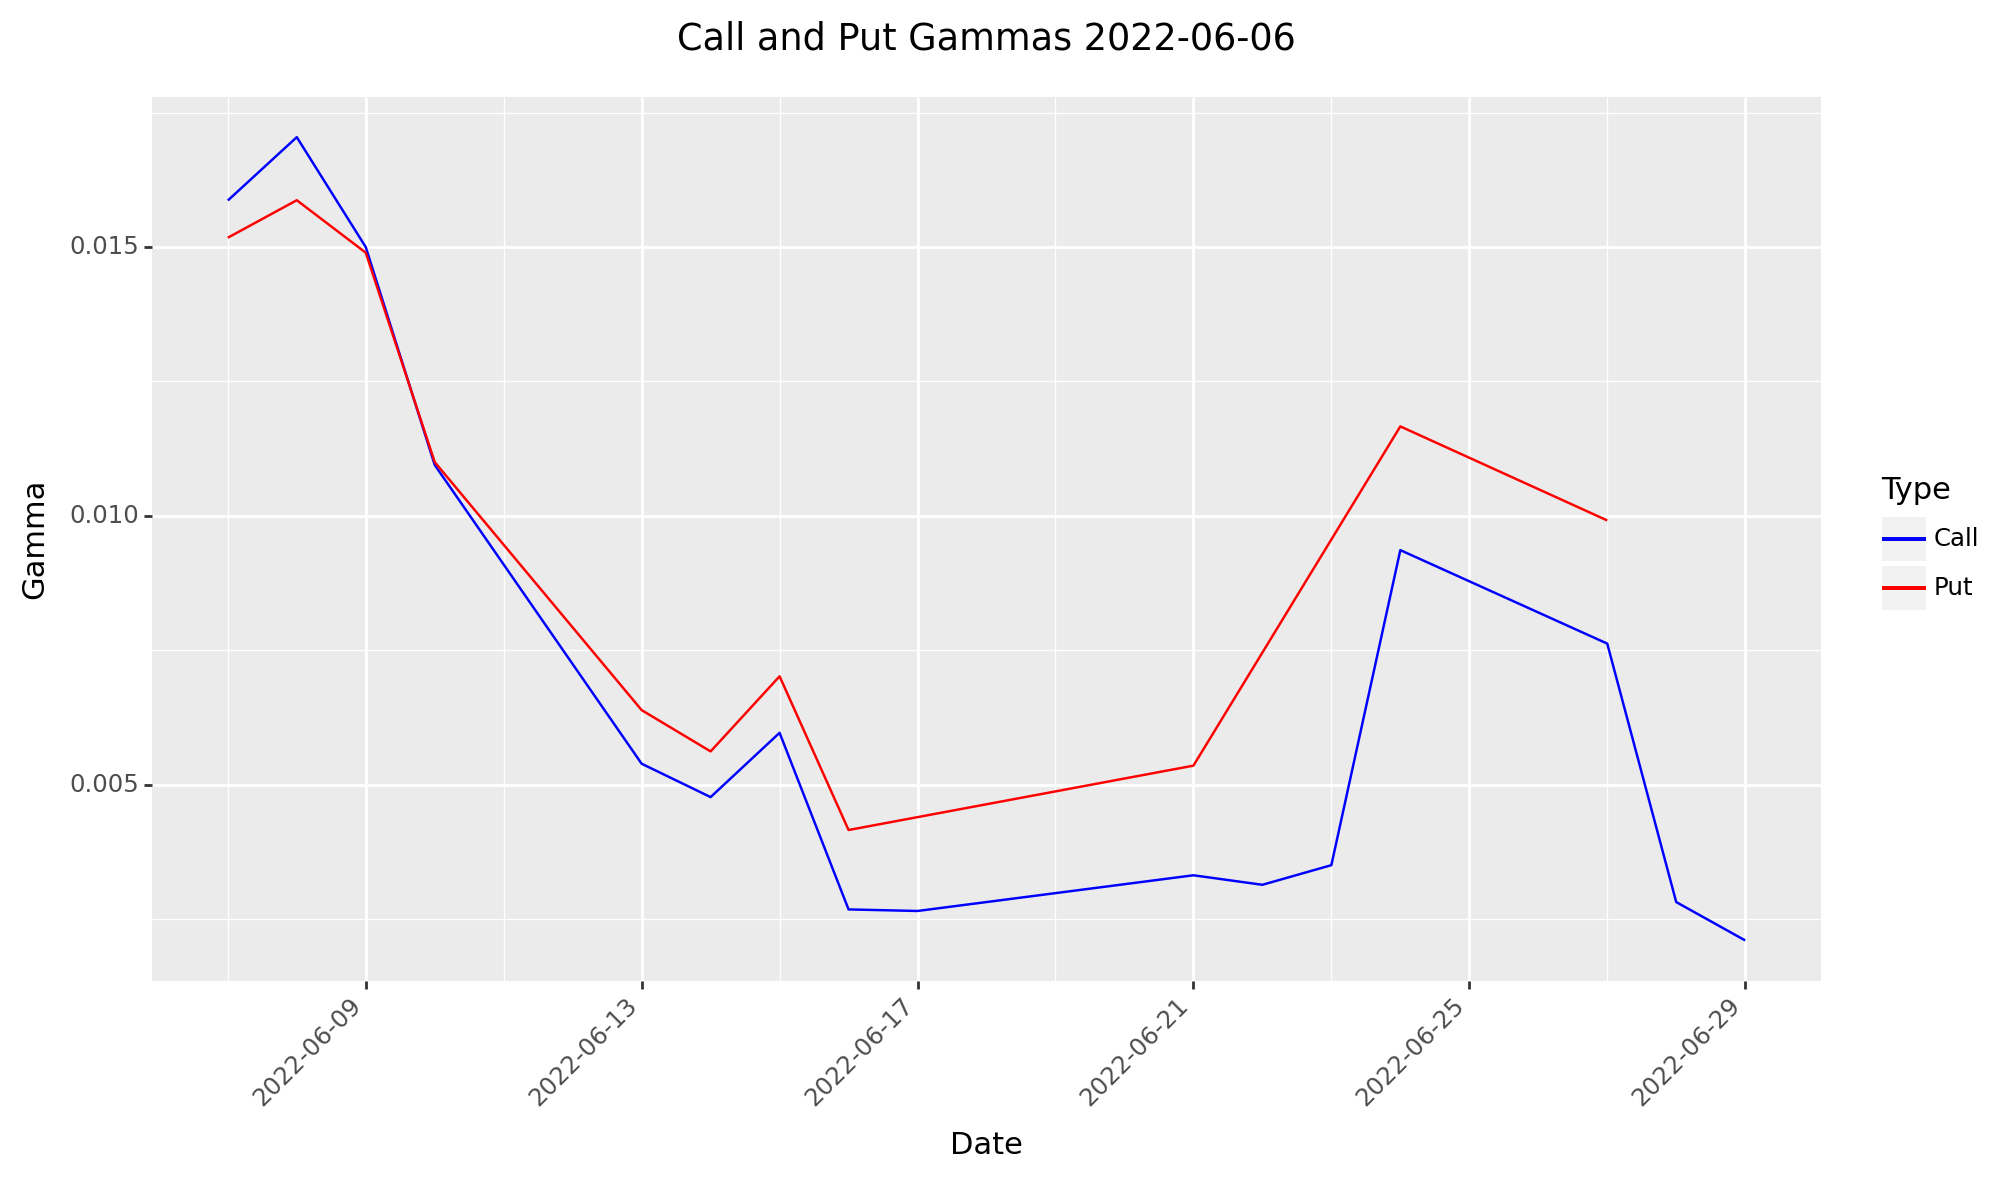

<Figure Size: (1000 x 600)>

In [96]:
p_g_3 = (ggplot(last_options, aes(x='date', y='gamma', color='Type')) +
           geom_line() +
           labs(title='Call and Put Gammas 2022-06-06', x='Date', y='Gamma', color='Type') +
           theme(axis_text_x=element_text(rotation=45, hjust=1),
                 figure_size=(10, 6),
                 plot_title=element_text(ha='center')) +
           scale_color_manual(values={"Call": "blue", "Put": "red"}))
p_g_3